# Social Media Sentiment Analysis

## Problem Statement

__BACKGROUND__

A large multinational corporation is seeking to automatically identify the sentiment that their customer base talks about on social media. They would like to expand this capability into multiple languages. Many 3rd party tools exist for sentiment analysis, however, they need help with under-resourced languages.

__GOAL__

Train a sentiment classifier (Positive, Negative, Neutral) on a corpus of the provided documents. Your goal is to maximize accuracy. There is special interest in being able to accurately detect negative sentiment. The training data includes documents from a wide variety of sources, not merely social media, and some of it may be inconsistently labeled. Please describe the business outcomes in your work sample including how data limitations impact your results and how these limitations could be addressed in a larger project.

__DATA__ 

Link to data: http://archive.ics.uci.edu/ml/datasets/Roman+Urdu+Data+Set

# Results and Recommendations 

## Model Description

We have developed a model that was able to achieve an overall accuracy of 63% accuracy, with a recall of 55% for negative sentiments. Per the problem statement, we optimized for overall accuracy. However, the model can be adjusted to increase sensitivity to "Negative" statements, albeit at the expense of overall accuracy. For example, if we would like to increase our negative sentiment recall to 68%, we decrease overall accuracy to 59%. 

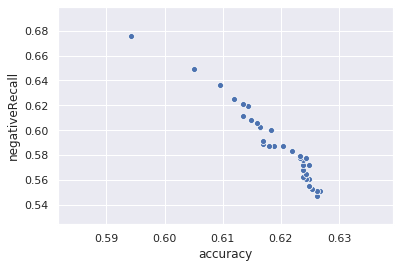

The model is based on an LSTM architecture, a type of neural network that performs well for data for which order is important, such as the order of words in text. We first explored a simpler "bag of words" approach that aims to understand the sentiment of each word and then considers the sentiment of the text to be the average sentiment of all its words. This approach performed very poorly, which led us to the more sophisticated LSTM model. 

An overview of our model development is below with all details in the appendix.

While the LSTM model performed markedly better than the "bag of words" model, its performance is still unsatisfactory. We have compile a list of several recommendations for improving this model. 

## Methodology Overview

In _Apppendix: Methodology_ we provide details - including all code - for the process by which we created the sentiment model. 

Here we provide a brief description of the process.

1. __Data Preparation:__ We loaded data into a DataFrame, corrected obvious data errors, and explored various properties of the data features. Of note, the text includes not just Romanized Urdu but also English, emoji's, empty text fields, and non-standard usage of punctuation and capitalization. 

2. __Text Parsing:__ With no prior knowledge of Urdu, we used default parsing techniques. We moved all text to lower case, broke sentences at end of word punctuation, and broke words at whitespace. We then removed remaining punctuation. Thus sentences consisted of lists of lower cased, punctuationless words and documents consisted of lists of sentences. 

3. __Word Embedding:__ We will be exploring embedding based solutions to the sentiment analysis problem so we build a word embedding using the word2vec algorithm. This is a standard option with a fast implementation.

4. __Model Exploration and Selection:__ We explore two model options: a "bag of words" based model and an LSTM based model. The "bag of words" approach learns sentiment based on the average of the embeddings of the words in the document. The LSTM based approach learns to sentiment by reading the sequence of words in sentence. The primary advantage of the "bag of words" approach is that it requires little data to learn. The LSTM model can achieve much better performance on sufficiently sized data. In our case, the LSTM outperformed the "bag of words" approach 
across a variety of parameters on the test data. 

5. __Model Tuning:__ We tuned the "LSTM" model against a variety of parameters. 

6. __Model Evaluation:__ We evaluate accuracy and "Negative" recall at a variety of classification thresholds.



## Recommendations for Model Improvement

In the course of constructing a sentiment classifier, we developed several recommendations that could improve the classifier.

- __Identify social media vs other__ Different media have different language usage. By developing a model based on non social media content we are essentially performing transfer learning (applying training from one data distribution to another). While transfer learning can be useful to augment a small data set, it can introduce bias into models.

- __Include time stamps__ Similarly, language usage shifts over time. By including a time component, we can identify model drift. 

- __Basic Urdu knowledge__ While much of language structure can be learned using a deep learning approach, we are helped by basic knowledge of language structure. Common text processing techniques for English such as stemming and parsing words by whitespace are based on a priori rules. In our work we used a minimal set of "reasonable" parsing rules, but greater confidence in these rules would be helpful. 

- __Get access to Urdu Embedding__ At the base of our model development was the creation of a word embedding. Access to a high quality embedding trained on a much larger Roman Urdu data set could be extremely useful.

- __Language classifier__ Some of the texts were exclusively in English. If we had a high quality English language classifier, we could apply English sentiment classifiers to those texts and remove them from our training. 


# Appendix: Methodology

In [1]:
# Import the necessary libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import pandas as pd
import numpy as np
import sklearn
import random as random
random.seed(5) 
import os
import keras as k
import csv
import pickle
import nltk
nltk.download('punkt')
from gensim.models import Word2Vec
import string
np.random.seed(34)
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform
import itertools
from gensim.test.utils import get_tmpfile, datapath
from gensim.models import KeyedVectors

Using TensorFlow backend.
[nltk_data] Downloading package punkt to /home/cfrailey/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Data Preparation



### Data Loading and Inspection

We first explore the data. We have been warned that the training data "includes documents from a wide variety of sources, not merely social media, and some of it may be inconsistently labeled" and we want to understand the implications of these challenges. 

We inspect data shape, sample the data, and look at basic column statistics.

In [2]:
# Load data as DataFrame using default encoding
data = pd.read_csv('RomanUrduDataSet.csv',sep=',',names=['text','sentiment'],index_col=False, 
                  quotechar='"' )

In [3]:
data.shape

(20229, 2)

In [4]:
data.sample(10)

,text,sentiment
18456,ALLAH THAALLAH HAM SAB P RAHEM FARMAY AMEEN SU...,Positive
7864,Iss News ka Source kia hay.,Neutral
274,Jizroor ..... Mei apne aunty ka dilse Shukriy...,Positive
5037,hahahhaah,Neutral
6358,Pir Pagara ne Muslim University Aligarh ke il...,Neutral
1185,Edhi Foundation Ambulance Service app kay beta...,Positive
5932,"Marka e Kargill ke dosre Nishan e Haider, Hava...",Neutral
15950,Plz mery liye b dua kariyga Mera Allah mjhsy R...,Positive
16051,Plz dow kar da mary or mary ghar waloo ka lia,Positive
10341,to gussy main kapre e mujhe de ti thi k ja ab ...,Negative


In [5]:
data.describe()

,text,sentiment
count,20228,20229
unique,19664,4
top,Good,Neutral
freq,23,8929


In [6]:
data.isna().sum()

text         1
sentiment    0
dtype: int64

Replace 'null' text with ''.

In [7]:
data['text'].fillna('', inplace = True)

In [8]:
data['sentiment'].value_counts()

Neutral     8929
Positive    6013
Negative    5286
Neative        1
Name: sentiment, dtype: int64

Classes are fairly balanced. 
However we need to correct mislabeled 'Neative' to 'Negative'

In [9]:
data.loc[data['sentiment'] == 'Neative', 'sentiment'] = 'Negative'

In [10]:
# Inspect data a bit more
data.sample(60)

,text,sentiment
16177,Allah apko jazaye khair dy hazrat sb,Neutral
11150,Baldia Muwach Goth Me Chhurio K War Se Shabana...,Negative
3717,good man,Positive
2689,abhi jab main Russia mein hone wale World Univ...,Positive
235,Allah ka shuakr hy ye tw hum per 😂,Positive
14489,Kya ye me b kr lu,Neutral
12053,Insaf ki farhami ki sorat e haal ye hai ke ko...,Negative
2781,1963 mein unhon ne apney adbi resala�EEE€�EEEF...,Positive
14965,bichary ko 2 chaperein paren,Negative
8208,...,Neutral


As a spotcheck for consistency, look for sentiment != 'Positive' and text == 'Good'.

In [11]:
sum((data['text'] == 'Good') & (data['sentiment'] != 'Positive'))

0

In [12]:
data['textLength'] = data['text'].apply(len)

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20229 entries, 0 to 20228
Data columns (total 3 columns):
text          20229 non-null object
sentiment     20229 non-null object
textLength    20229 non-null int64
dtypes: int64(1), object(2)
memory usage: 474.2+ KB


I will look at the text distribution to see if there are clear clusters that might indicate content from social media or not. If so we can evaluate our models against these different clusters. Or we could inspect ourliers and consider how to treat them.

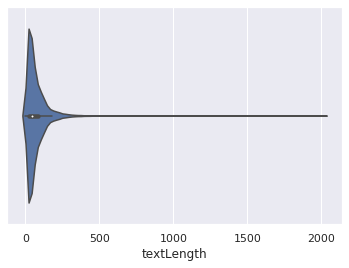

In [14]:
sns.violinplot(data['textLength'])

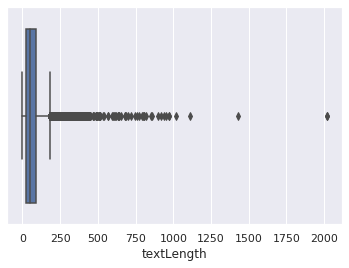

In [15]:
sns.boxplot(data['textLength'])

Nothing seems obvious here.

### Text Parsing

This is an area where lack of knowledge of the language can be quite a hinderance. We use what we consider a conservative approach to text parsing. 

We lower case, tokenize sentences using defaults, tokenize words using defaults, then strip whitespace and punctuation.

In [16]:
def UrduParsing(text):
    # create list of sentences in text
    sentences = nltk.sent_tokenize(text.lower())
    # create list of lists of words in sentences and remove whitespace and punctuation
    wordsInSentences = [nltk.word_tokenize(s) for s in sentences]
    
    # loop through words to remove whitespace and punctuation and remove empty words
    cleanWordsInSentences = []
    table = str.maketrans({key: None for key in string.punctuation+string.whitespace})
    for s in wordsInSentences:
        cleanSentence = []
        for w in s:
            cleanWord = w.translate(table)
            if len(cleanWord) > 0:
                cleanSentence.append(cleanWord)
        if len(cleanSentence) > 0:
            cleanWordsInSentences.append(cleanSentence)
    
    return cleanWordsInSentences

In [17]:
data['parsedText'] = data.apply(lambda x: UrduParsing(x['text']), axis = 1)

In [18]:
data.sample(20)

,text,sentiment,textLength,parsedText
15906,yahan par personal batain na karain,Neutral,35,"[[yahan, par, personal, batain, na, karain]]"
6597,Musharraf Rebuff jis mein Musharraf aamriyat k...,Neutral,236,"[[musharraf, rebuff, jis, mein, musharraf, aam..."
14566,Ena sona kiun rab ne bnaya,Positive,27,"[[ena, sona, kiun, rab, ne, bnaya]]"
15223,Terian tak ky adavaan my Mureed ho gia,Positive,38,"[[terian, tak, ky, adavaan, my, mureed, ho, gia]]"
2102,dua Karo :p,Positive,11,"[[dua, karo, p]]"
15002,Imran Khan ki b najaiz olad hai AP bhol rahy h...,Negative,55,"[[imran, khan, ki, b, najaiz, olad, hai, ap, b..."
14064,bhala ho punjab walo ka,Positive,23,"[[bhala, ho, punjab, walo, ka]]"
13690,Hota hai .. chalta haii .. facebook hai ..,Neutral,43,"[[hota, hai, chalta, haii, facebook, hai]]"
4851,Amna Abbasi 😃😃😃😃,Neutral,16,"[[amna, abbasi, 😃😃😃😃]]"
18643,Aam Entehabatma any chahiye,Neutral,27,"[[aam, entehabatma, any, chahiye]]"


We will now look for the distribution of word frequency.

In [19]:
tally = {}
for l in data['parsedText']:
    for s in l:
        for w in s:
            if (w in tally.keys()):
                tally[w] += 1
            else:
                tally[w] = 1

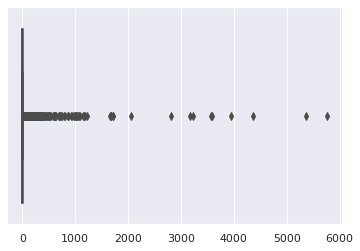

In [20]:
sns.boxplot(list(tally.values()))

In [21]:
parsedWordFrequency = pd.DataFrame(list(tally.items()), columns=('word','frequency'))
parsedWordFrequency = parsedWordFrequency.sort_values(by = 'frequency', ascending = False)
print('there are ' + str(parsedWordFrequency.shape[0]) + ' distince words')
print(str(sum(parsedWordFrequency['frequency'] == 1)) + ' of those words only appear once')
print(str(sum(parsedWordFrequency['frequency'] < 4)) + ' of those words only appear less than 4 times')

there are 33479 distince words
19460 of those words only appear once
26139 of those words only appear less than 4 times


58% of words only appear once. 

In [22]:
parsedWordFrequency.head(3)

,word,frequency
7,ki,5759
314,ke,5357
305,mein,4367


### Test/Train Split

In [23]:
from sklearn.model_selection import train_test_split

pT_train, pT_test, s_train, s_test = train_test_split(data['parsedText'], data['sentiment'], 
                                                    test_size=.1, 
                                                    random_state=0)

## Model Development

### Word Embedding via Word2Vec

A word embedding is a function by which words are represented as vectors in a space. The function tries to assign words to vectors in such a way that _similar_ words are sent to _close_ vectors and _dissimilar_ words are sent to _distant_ vectors. Different word embedding algorithms have different means of determining _similarity_/_dissimilarity_ and _close_/_distant_ but we chose the Word2Vec algorithm which is very popular and has a fast implementation. We will test our models' performances against different parameters for the embedding. 

As our corpus is quite small and we have no third party pretrained embeddings on which to evaluate our own, this could be a fruitful area for further development.

__Employ Word2Vec in gensim__

We set _min count_ (minimum number of word occurences) of 2. This is very conservative and only removes words for which we have strongest confidence would only add noise (as we wouldn't be able to learn confident vectors for one occurence).

We scan through setting _size_ (dimension of embedding space) at 20, 50, and 100.

We scan through _window_ (words on either side to be considered for content-target pairs) at 2, 5, 7.

In [24]:
# create list of parsed sentences to pass to Word2Vec
words_in_sentences = []
for l in data['parsedText']:
    words_in_sentences += l

# Create Embeddings for sizes of 10, 50, 100 and windows of 2,5,7
sizes = [10,50,100]
windows = [2,5,7]

word2vec = {(s,w): Word2Vec(words_in_sentences, min_count = 2, size = s, seed = 28, window = w) 
            for (s,w) in itertools.product(sizes,windows)}

In [25]:
word2vec[(50,7)].wv.most_similar('allah')

[('ameen', 0.9956144094467163),
 ('pak', 0.9951152801513672),
 ('sum', 0.9945386648178101),
 ('rakhy', 0.993998646736145),
 ('farma', 0.9939974546432495),
 ('masha', 0.9934855699539185),
 ('subhan', 0.9934506416320801),
 ('hidayat', 0.9933172464370728),
 ('salamat', 0.993302583694458),
 ('lambi', 0.993212103843689)]

In [26]:
word2vec[(100,2)].wv.most_similar('good')

[('very', 0.9983828067779541),
 ('a', 0.9980259537696838),
 ('nice', 0.9977725744247437),
 ('with', 0.9977163076400757),
 ('it', 0.9976974129676819),
 ('i', 0.9976713061332703),
 ('so', 0.9976514577865601),
 ('u', 0.9976493716239929),
 ('and', 0.99761962890625),
 ('have', 0.9976001977920532)]

### Model 1: Bag of Words Approach

In this approach, each document is assigned to the center of the embeddings of the words in the document. We then train a linear function with a softmax layer to the data. 

In [27]:
def centerOfWords(words_in_sentences, vocab, w2v):
    # Input:
    # words_in_sentences - list of list of words representing a sequence of sentences
    # vocab - words for which we have an embedding
    # w2v - Word2Vec object
    # Returns:
    # Center of mass of words in sentences, normalized to have L2 norm of 1 if non-zero
    
    embed_dim = w2v[random.sample(vocab,1)].shape[1]
    
    center = np.zeros(embed_dim)
    
    for s in words_in_sentences:
        for w in s:
            if w in vocab:
                center += w2v[w]
    
    if np.count_nonzero(center) == 0:
        return center
    
    else:
        return center/np.sqrt(np.dot(center,center))

In [28]:
def softmax(x):
    # Input:
    # x - (m,2) np.array
    # Returns:
    # (m,1) np.array with softmax of x over axis=1
    
    return np.exp(x)/np.sum(np.exp(x), axis=1)

In [29]:
def categorify(sentiment):
    # Input:
    # sentiment - string
    # Returns:
    # One hot encoding of sentiment
    
    if sentiment == 'Neutral':
        return [0,1,0]
    elif sentiment == 'Positive':
        return [0,0,1]
    elif sentiment == 'Negative':
        return [1,0,0]
    else:
        raise('Inappropriate Category')

In [30]:
def convert_to_one_hot(x):
    # Input:
    # x - (m,) pd.Series of sentiments
    # Returns:
    # (m,3) np.array of one hot encodings of sentiments
    
    return np.array([categorify(i) for i in x])

In [31]:
def forwardPropNaiveModel(X,W,b):
    # Input:
    # X - (m, dimEmbedding) np.array of the center of mass of the observations
    # W,b - (dimEmbedding, 3) (1,3) np.arrays for linear transformation
    # Returns:
    # the (m,3) np.array resulting from the linear transformation followed by softmax
    
    Z = np.atleast_2d(np.dot(X,W) + b)
    A = np.exp(Z)/np.atleast_2d(np.sum(np.exp(Z), axis = 1)).T
    return(A)

In [32]:
def predictNaiveModel(X,W,b,weights):
    # Input:
    # X - (m, dimEmbedding) np.array of the center of mass of the observations
    # W,b - (dimEmbedding, 3) (1,3) np.arrays for linear transformation
    # weights - (1,3) np.array to of weights to classifiers used to change classifier threshold
    # Returns:
    # 
    
    A = forwardPropNaiveModel(X,W,b)*weights
    pred = np.argmax(A,axis=1)
    return pred

In [33]:
def prepXY(texts, sentiments, wv):
    # Input:
    # texts - (m,) pd.Series of texts to be converted to their center of mass
    # sentiments - (m,) pd.Series of sentiments to be converted to one hot encodings
    # wv - Word2Vec object
    # Returns:
    # X - (m, dimEmbedding) center of mass of texts
    # Y - (m, 3) one hot encoded sentiments
    
    X = np.array([centerOfWords(texts.iloc[i], set(wv.vocab.keys()), wv) for i in range(texts.shape[0])])
    Y = np.array([categorify(sentiments.iloc[i]) for i in range(sentiments.shape[0])])
    return X,Y

In [34]:
def evaluateNaiveModel(texts, sentiments, wv, W, b, weights = np.reshape(np.array([1,1,1]),(1,3))):
    # Input:
    # texts - (m,) pd.Series of texts
    # sentiments - (m,) pd.Series of sentiments
    # W,b - (dimEmbedding, 3) (1,3) np.arrays for linear transformation
    # weights - (1,3) np.array to of weights to classifiers used to change classifier threshold
    # Returns:
    # confMat - (3,3) confusion matrix
    # Ylabels - (m,) actual sentiment [0-2] for
    # Yhat - (m,) predicted sentiment [0-2]
    
    X,Y = prepXY(texts, sentiments, wv)
    Ylabels = np.argmax(Y,axis = 1)
    Yhat = predictNaiveModel(X,W,b,weights)
    confMat = LazyConfMat(Ylabels,Yhat)
    return confMat,Ylabels,Yhat

In [35]:
def bagOfWordsmodel(X, Y, learning_rate, num_iterations):
    # Input:
    # X -- numpy array of sentences as strings, of shape (m, 1)
    # Y -- labels, numpy array of integers between 0 and 7, numpy-array of shape (m, 1)
    # word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    # learning_rate -- learning_rate for the stochastic gradient descent algorithm
    # num_iterations -- number of iterations   
    # Returns:
    # pred -- vector of predictions, numpy-array of shape (m, 1)
    # W -- weight matrix of the softmax layer, of shape (n_y, n_h)
    # b -- bias of the softmax layer, of shape (n_y,)
    
    np.random.seed(23)

    m = Y.shape[0]
    n_y = Y.shape[1]
    n_h = X.shape[1]
    
    W = np.random.randn(n_h, n_y) / np.sqrt(n_h)
    b = np.zeros((1,n_y))
    
    # Optimization loop
    for t in range(num_iterations):                       # Loop over the number of iterations
        tot_cost = 0
        for i in range(m):                                # Loop over the training examples
            
            # Forward propagate the avg through the softmax layer
            z = np.dot(X[i,:],W) + b
            a = softmax(z)

            # Compute cost using the i'th training label's one hot representation and "A" (the output of the softmax)
            cost = -1*np.sum(Y[i,:]*np.log(a))
            
            tot_cost+= cost
            ### END CODE HERE ###
            
            # Compute gradients 
            dz = a - Y[i,:]
            dW = np.dot(X[i,:].reshape(n_h,1),dz.reshape(1,n_y))
            db = dz

            # Update parameters with Stochastic Gradient Descent
            W = W - learning_rate * dW
            b = b - learning_rate * db
        
        if t == 0:
            print("Epoch: " + str(t) + " --- cost = " + str(tot_cost))
        
    print("Epoch: " + str(t) + " --- cost = " + str(tot_cost))

    return W, b

In [36]:
# We will scan through a few learning rates
learningRates = [.1,.01,.001]

In [37]:
Y = np.array([categorify(s_train.iloc[i]) for i in range(s_train.shape[0])])

modelRuns = {}

# train bag of words against various embedding dimensions (sizes), window sizes, and learning rates
for (s, w, l) in itertools.product(sizes, windows, learningRates):
    wv = word2vec[(s,w)].wv
    X, Y = prepXY(pT_train, s_train, wv)
    modelRuns[(s,w,l)] = bagOfWordsmodel(X, Y, learning_rate = l, num_iterations = 10)

Epoch: 0 --- cost = 19660.817935247167
Epoch: 9 --- cost = 19420.520848972006
Epoch: 0 --- cost = 19466.832241487395
Epoch: 9 --- cost = 19006.00269863968
Epoch: 0 --- cost = 19669.893203813186
Epoch: 9 --- cost = 19254.114209538635
Epoch: 0 --- cost = 19628.66266522364
Epoch: 9 --- cost = 19309.289398115445
Epoch: 0 --- cost = 19471.331252783533
Epoch: 9 --- cost = 18954.579366210008
Epoch: 0 --- cost = 19695.30372040534
Epoch: 9 --- cost = 19244.25308158631
Epoch: 0 --- cost = 19574.14547523097
Epoch: 9 --- cost = 19205.746989203704
Epoch: 0 --- cost = 19414.11229642964
Epoch: 9 --- cost = 18885.618935650207
Epoch: 0 --- cost = 19684.167206446797
Epoch: 9 --- cost = 19186.530191894864
Epoch: 0 --- cost = 19737.24023569078
Epoch: 9 --- cost = 19411.033757292014
Epoch: 0 --- cost = 19468.522922604334
Epoch: 9 --- cost = 19107.356854164245
Epoch: 0 --- cost = 19618.244641875408
Epoch: 9 --- cost = 19284.14159160386
Epoch: 0 --- cost = 19703.895572566424
Epoch: 9 --- cost = 19371.9913440

In [38]:
def LazyConfMat(Ylabels, Yhat):
    # Input:
    # Ylabels - (m,) true labels [0-2]
    # Yhat - (m,) predicted labels [0-2]
    # Returns 
    confMat = np.zeros((3,3))
    for i in range(3):
        for j in range(3):
            confMat[i,j] = sum((Ylabels[:] == j) * (Yhat[:] == i))
            
    return confMat

In [39]:
# evaluate models to see performance

for s,w,l in itertools.product(sizes,windows,learningRates):
    wv = word2vec[(s,w)].wv
    W, b = modelRuns[(s,w,l)]
    cf,_,_ = evaluateNaiveModel(pT_test, s_test, wv, W, b)
    print("For size {}, window {}, learning rate {} the conf mat is ".format(str(s),str(w),str(l)))
    print(cf)
    accuracy = np.sum(np.diagonal(cf))/np.sum(cf)
    negRecall = cf[0,0]/np.sum(cf[:,0])
    print("the accuracy is "+ str(accuracy) + " and recall for Negative sentiment is " + str(negRecall) +".\n")

For size 10, window 2, learning rate 0.1 the conf mat is 
[[414. 582. 303.]
 [ 42. 180.  62.]
 [ 72. 164. 204.]]
the accuracy is 0.3944636678200692 and recall for Negative sentiment is 0.7840909090909091.

For size 10, window 2, learning rate 0.01 the conf mat is 
[[  1.   3.   0.]
 [416. 744. 360.]
 [111. 179. 209.]]
the accuracy is 0.47157686604053384 and recall for Negative sentiment is 0.001893939393939394.

For size 10, window 2, learning rate 0.001 the conf mat is 
[[  0.   0.   0.]
 [522. 909. 549.]
 [  6.  17.  20.]]
the accuracy is 0.4592189817103312 and recall for Negative sentiment is 0.0.

For size 10, window 5, learning rate 0.1 the conf mat is 
[[421. 571. 303.]
 [ 36. 184.  70.]
 [ 71. 171. 196.]]
the accuracy is 0.39594661393969355 and recall for Negative sentiment is 0.7973484848484849.

For size 10, window 5, learning rate 0.01 the conf mat is 
[[  2.   4.   0.]
 [414. 694. 321.]
 [112. 228. 248.]]
the accuracy is 0.4666337123084528 and recall for Negative sentiment i

Accuracy stays < 50%. Recall for negative sentiment is all over the place. We could try to play with parameters , but this doesn't look fruitful.

#### Findings

This bag of words approach is essentially runs a linear regression on the average of the word embeddings in each text. The fact that it performs so poorly indicates that either our embedding quality is quite low or that the structure of the sentences is very important or both.

### Model 2: LSTM Based Model

We saw that the "bag of words" approach was insufficient, suggesting that we need to develop a model that captures not just the set of words in a text but the order of those words. 

To this end, we employ an LSTM ("Long Short Term Memory") based neural net model. LSTM based models evaluate sequential data and learn if and how much of the past is important to predict some value. In our case, the LSTM model will hopefully read the text left to right and continuously decide if and which of the content that it has read will be useful to deciding the sentiment of the text. Again, this is in contrast to the "bag of words" approach that looks at all words in the text at once tries to decide sentiment. 

In [40]:
def word2indexMapBuilder(wv):
    # Input:
    # wv - Word2Vec object
    # Returns:
    # dictionary mapping range(len(wv.vocab)) -> vocab
    
    word2index = {w:i for i,w in enumerate(wv.vocab)}
    return word2index

In [41]:
def embeddingLayer(wv, word2index):
    # Input:
    # wv - Word2Vec object
    # word2index - dict word in vocab -> index 
    # Returns:
    # Keras embedding layer
    
    # get dimension of embedding space
    embDim = wv[random.sample(list(wv.vocab),1)].shape[1]
    
    # get vocablen + 1 
    vocabLen1 = len(wv.vocab)
    
    # initialize embedding matrix
    embMat = np.zeros((vocabLen1,embDim))
    
    # fill in embedding matrix with embedding from wv
    for w,i in word2index.items():
        embMat[i,:] = wv[w]
    
    # set trainable = True bc we have low confidence in the quality of our embeddings
    embLayer = Embedding(output_dim=embDim, input_dim=vocabLen1, trainable = True)
    embLayer.build((None,))
    embLayer.set_weights([embMat])
    
    return embLayer
    

In [42]:
def sentimentLSTM(wv, word2index, maxLen):
    # Input:
    # wv - Word2Vec object
    # word2index - dict word in vocab -> index 
    # maxLen - some documents are extremely large so we will only train on their first maxLen words
    
    # Input will be the word indices
    wordIndices = Input(shape=(maxLen,),dtype='int32')
    
    # Create the embedding layer from the trained embedding
    embedding_layer = embeddingLayer(wv,word2index)
    embeddings = embedding_layer(wordIndices)
    
    # 128 dim LSTM layer 
    X = LSTM(128, return_sequences = True)(embeddings)
    # Dropout layer
    X = Dropout(.5)(X)
    # Another 128 dim LSTM layer
    X = LSTM(128)(X)
    # Dropout layer
    X = Dropout(.5)(X)
    # Dense layer with softmax activation to learn the 3 dim classification
    X = Dense(3, activation='softmax')(X)
    # Add a softmax activation
    X = Activation(activation='softmax')(X)
    
    model = Model(inputs=[wordIndices],outputs=[X])
    
    return model

In [43]:
def prepXYforLSTM(word2index,pT_train, pT_test, s_train, s_test, maxLen):
    
    m_train = len(pT_train)
    m_test = len(pT_test)
    
    X_train = np.zeros((m_train, maxLen))
    
    X_test = np.zeros((m_test, maxLen))
    
    Y_train = convert_to_one_hot(s_train)
    
    Y_test = convert_to_one_hot(s_test)
    
    for i in range(m_train):
        sentences_concat = []
        for s in pT_train.iloc[i]:
            sentences_concat += s
        for j in range(maxLen):
            try:
                X_train[i,j] = word2index[sentences_concat[j]]
            except:
                pass
    
    for i in range(m_test):
        sentences_concat = []
        for s in pT_test.iloc[i]:
            sentences_concat += s
        for j in range(maxLen):
            try:
                X_test[i,j] = word2index[sentences_concat[j]]
            except:
                pass    
            
    return X_train, X_test, Y_train, Y_test
    

In [44]:
# train models for different sizes, windows, and maxlens 
# evaluate against test data

maxLens = [10,20]

LSTMmodels = {}
LSTMmodelPerf = {}

for s,w,m in itertools.product(sizes, windows, maxLens):
    wv = word2vec[(s,w)].wv
    word2index = word2indexMapBuilder(wv)
    
    LSTMmodels[(s,w,m)] = sentimentLSTM(wv, word2index,m)
    
    LSTMmodels[(s,w,m)].compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    X_train, X_test, Y_train, Y_test = prepXYforLSTM(word2index,pT_train, pT_test, s_train, s_test, m)
    
    # fit model
    LSTMmodels[(s,w,m)].fit(X_train, Y_train, epochs = 5, batch_size = 32, shuffle=True, validation_split=.1)
    
    
    _, acc = LSTMmodels[(s,w,m)].evaluate(X_test, Y_test)
    
    Yhat = np.argmax(LSTMmodels[(s,w,m)].predict(X_test),axis=1)
    Ylabels = np.argmax(Y_test,axis=1)
    
    confMat = LazyConfMat(Ylabels, Yhat)
    
    LSTMmodelPerf[(s,w,m)] = {'accuracy':acc, 'confMat':confMat}
    

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 16385 samples, validate on 1821 samples
Epoch 1/5
16385/16385 [==============================] - 18s 1ms/step - loss: 1.0455 - acc: 0.4629 - val_loss: 1.0168 - val_acc: 0.4964
Epoch 2/5
16385/16385 [==============================] - 16s 985us/step - loss: 0.9951 - acc: 0.5238 - val_loss: 0.9705 - val_acc: 0.5481
Epoch 3/5
16385/16385 [==============================] - 16s 980us/step - loss: 0.9007 - acc: 0.6387 - val_loss: 0.9635 - val_acc: 0.5607
Epoch 4/5
16385/16385 [==============================] - 16s 972us/step - loss: 0.8198 - acc: 0.7253 - val_loss: 0.9540 - val_acc: 0.5810
Epoch 5/5
2023/2023 [==============================] - 0s 203us/step
Train on 16385 samples, validate on 1821 samples
Epoch 1/5
16385/16385 [=========================

In [45]:
with open('obj/LSTMmodels.pkl', 'wb') as output:
    pickle.dump(LSTMmodelPerf,output, pickle.HIGHEST_PROTOCOL)
    
with open('obj/LSTMmodelPerf.pkl', 'wb') as output:
    pickle.dump(LSTMmodelPerf, output, pickle.HIGHEST_PROTOCOL)

After 4 or 5 epochs, learning rates of .01 and .1 start to overfit as seen by the validation accuracy beginning to dip. 

The model with size =  100, window = 5, and maxLen = 20 has highest validation accuracy (.643) and is therefore used. We assess it's performance on the test set.

In [55]:
cf = LSTMmodelPerf[(100,5,20)]['confMat']

accuracy = np.sum(np.diagonal(cf))/np.sum(cf)
negRecall = cf[0,0]/np.sum(cf[:,0])
print("the accuracy is "+ str(accuracy) + " and recall for Negative sentiment is " + str(negRecall) +".\n")

the accuracy is 0.6262975778546713 and recall for Negative sentiment is 0.5454545454545454.



We can alter the model to be more sensitive to negative sentiment weighting.

In [56]:
model = LSTMmodels[(100,5,20)]
negWeights = 1.05+ np.arange(34)*.05
accNegRecall = pd.DataFrame(columns=['accuracy','negativeRecall'])
i = 0

for w in negWeights:
    weights = np.atleast_2d([w,1,1])
    
    Yhat = np.argmax(model.predict(X_test)*weights, axis = 1)
    Ylabels = np.argmax(Y_test,axis=1)

    cf = LazyConfMat(Ylabels, Yhat)
    
    accuracy = np.sum(np.diagonal(cf))/np.sum(cf)
    negRecall = cf[0,0]/np.sum(cf[:,0])
    
    accNegRecall.loc[i]=[accuracy, negRecall]
    i+=1
    
    print("""By upweighting the Negative sentiment signal by a factor of {},
    we increased negative recall to {} but accuracy decreases to {}.""".format(w,negRecall,accuracy))

By upweighting the Negative sentiment signal by a factor of 1.05,
    we increased negative recall to 0.5473484848484849 but accuracy decreases to 0.6262975778546713.
By upweighting the Negative sentiment signal by a factor of 1.1,
    we increased negative recall to 0.5511363636363636 but accuracy decreases to 0.6267918932278794.
By upweighting the Negative sentiment signal by a factor of 1.1500000000000001,
    we increased negative recall to 0.5511363636363636 but accuracy decreases to 0.6262975778546713.
By upweighting the Negative sentiment signal by a factor of 1.2000000000000002,
    we increased negative recall to 0.553030303030303 but accuracy decreases to 0.625308947108255.
By upweighting the Negative sentiment signal by a factor of 1.25,
    we increased negative recall to 0.5549242424242424 but accuracy decreases to 0.6248146317350469.
By upweighting the Negative sentiment signal by a factor of 1.3,
    we increased negative recall to 0.5549242424242424 but accuracy decreas

#### Findings

The LSTM based model learns much better than the "bag of words" model and can be adjusted to increase sensitivity to negative sentiments if desired. We plot this tradeoff.

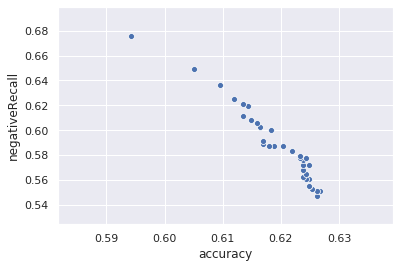

In [57]:
sns.scatterplot(x='accuracy',y='negativeRecall',data=accNegRecall)